In [1]:
import scanpy as sc
import squidpy as sq

import numpy as np
import pandas as pd

In [40]:
adata = sc.read_h5ad('datasets/slideseqv2/slideseqv2_raw.h5ad')
adata = adata[:,adata.var['highly_variable_rank']<2000].copy()
sc.pp.filter_cells(adata,min_genes=20)
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.obs['maxval'] = adata.obsm['deconvolution_results']['maxval'].values


import os
from pathlib import Path
directory = Path('Benchmarking_results/slide-seqv2')
glb = directory.rglob('*.npy')
files = [str(file) for file in glb if file.is_file()]
file_list = sorted(files)

for filename in file_list:
    name = filename[33:-4]
    if name not in ['GraphST'+str(i) for i in range(10)]:
        adata.obsm[name] = np.load(filename)
    
#for i in range(10):
#    adata.obsm['GraphST'+str(i)] = sc.pp.pca(adata.obsm['GraphST'+str(i)])


from simvi.model import SimVI
edge_index = SimVI.extract_edge_index(adata,n_neighbors=10)
import numpy as np
from scipy.sparse import coo_matrix, csr_matrix
coo = coo_matrix((np.ones(edge_index[0].shape[0]), (edge_index[0].numpy(), edge_index[1].numpy())), shape=(adata.shape[0],adata.shape[0]))
for i in range(10):
    adata.obsm['scviavg2k'+str(i)] = 0.1 * coo.toarray() @ adata.obsm['scvi2k'+str(i)]
    adata.obsm['cellcharter2k'+str(i)] = np.hstack((adata.obsm['scvi2k'+str(i)],adata.obsm['scviavg2k'+str(i)]))

In [45]:
adata

AnnData object with n_obs × n_vars = 32838 × 2000
    obs: 'barcode', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'leiden', 'cluster', 'n_genes', 'maxval'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'spatial_neighbors', 'umap', 'log1p'
    obsm: 'X_pca', 'X_umap', 'deconvolution_results', 'spatial', 'GraphST0', 'GraphST1', 'GraphST2', 'GraphST3', 'GraphST4', 'GraphST5', 'GraphST6', 'GraphST7', 'GraphST8', 'GraphST9', 'STAGATE0', 'STAGATE1', 'STAGATE2', 'STAGATE3', 'STAGATE4', 'STAGA

In [4]:
sc.pp.neighbors(adata,use_rep='simvi2k_s2')
sc.tl.leiden(adata,resolution=0.55)

2024-04-19 02:01:41.361112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


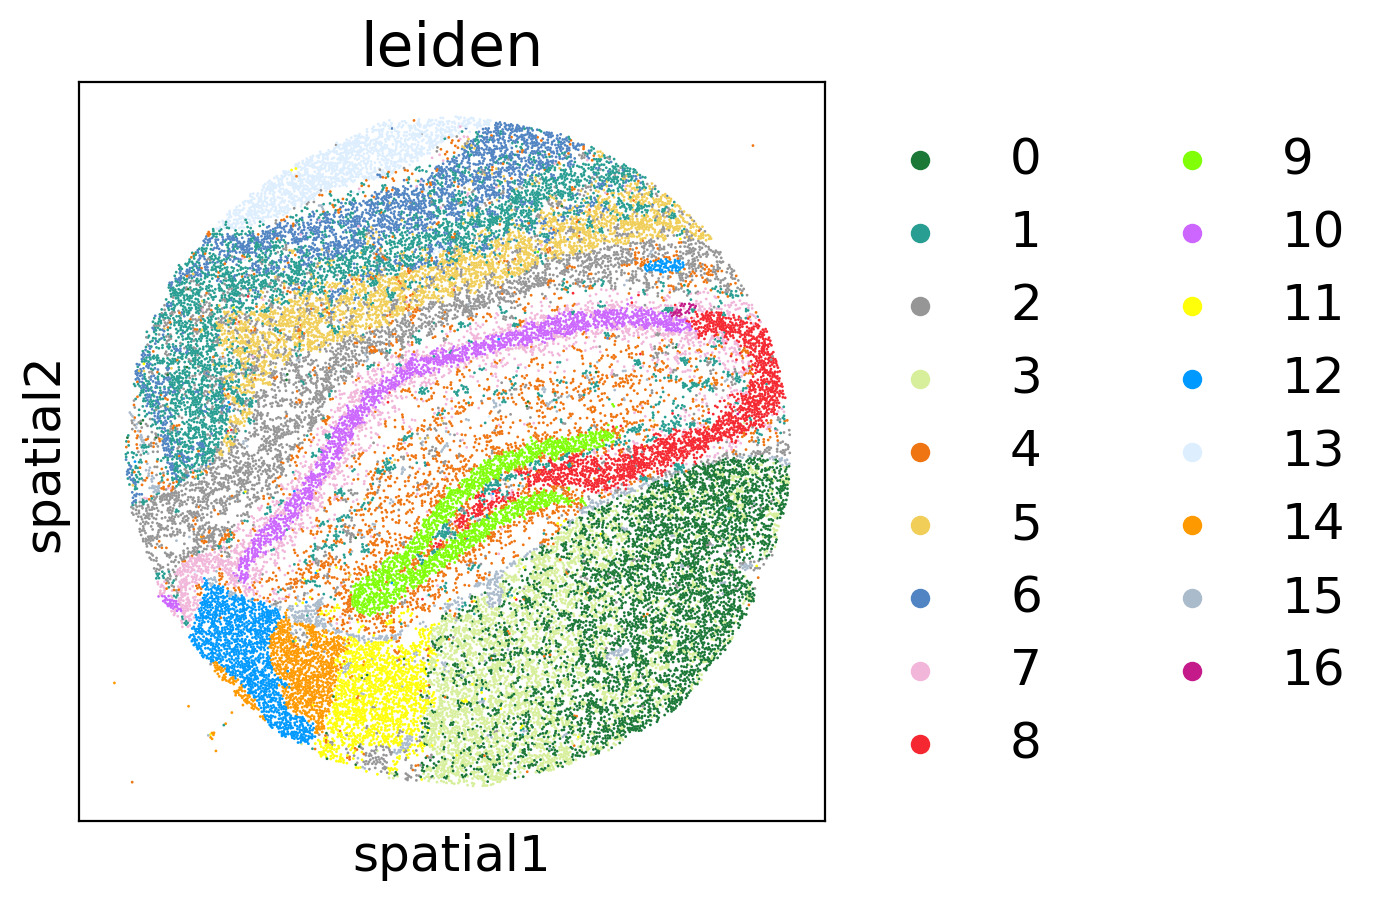

In [5]:
palette_20_ = [
    '#1b7837',
    '#289E92',
    '#969696',
    '#D7EF9B',
    '#EF7512',
    '#F0CE58',
    '#5084C2',
    '#f1b6da',
    '#F52831',
    '#80FF08',
    '#CC66FF',
    '#FFFF0A',
    '#0099FF',
    '#DDEEFF',
    '#FF9900',
    '#AABBCC',
    '#c51b8a']
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams["font.size"] = 18
sc.pl.spatial(adata,color=['leiden'],wspace=1,spot_size=20,palette=palette_20_)

In [36]:
#sc.pp.pca(adata)
s_list = [file[33:-4] for file in file_list]
s_list.extend(['cellcharter'+str(i) for i in range(10)])
s_list.append('X_pca')
z_ = ['simvi_lz'+str(i) for i in range(10)]
z_.extend(['simvi_z'+str(i) for i in range(10)])
#z_.extend(['simvi_s'+str(i) for i in range(10)])
z_.extend(['simvi2k_z'+str(i) for i in range(10)])
z_.extend(['simvi2k_lz'+str(i) for i in range(10)])

s_ = ['simvi_lz'+str(i) for i in range(10)]
s_.extend(['simvi_z'+str(i) for i in range(10)])
s_.extend(['simvi_s'+str(i) for i in range(10)])
s_.extend(['simvi2k_s'+str(i) for i in range(10)])
s_.extend(['simvi2k_lz'+str(i) for i in range(10)])
nsf_z = ['nsf_z'+str(i) for i in range(10)]
nsf_z.extend(['mefisto_z0'])

s_list = [item for item in s_list if item not in nsf_z]

z_list = [item for item in s_list if item not in s_]
s_list = [item for item in s_list if item not in z_]

In [42]:
s2k_list = ['scvi2k'+str(i) for i in range(10)]
s2k_list.extend(['simvigo2k_s'+str(i) for i in range(10)])
s2k_list.extend(['simvigoct2k_s'+str(i) for i in range(10)])
s2k_list.extend(['cellcharter2k'+str(i) for i in range(10)])

In [43]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
biocons = BioConservation(isolated_labels=False,nmi_ari_cluster_labels_leiden=True,nmi_ari_cluster_labels_kmeans=False,clisi_knn=False)
bat = BatchCorrection(silhouette_batch = False, ilisi_knn=False, kbet_per_label = False, graph_connectivity = False, pcr_comparison=False)

bm = Benchmarker(
    adata,
    batch_key="cluster",
    label_key="leiden",
    embedding_obsm_keys=s2k_list,
    pre_integrated_embedding_obsm_key='X_pca',
    bio_conservation_metrics=biocons,
    batch_correction_metrics=bat,
    n_jobs=20,
)
bm.benchmark()
bm._results.to_csv('Benchmarking_results/slideseqv2_simviniche_2k.csv')

/usr/local/lib/python3.8/dist-packages/scib_metrics/benchmark/_core.py:178: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._emb_adatas[emb_key] = AnnData(self._adata.obsm[emb_key], obs=self._adata.obs)
/usr/local/lib/python3.8/dist-packages/scib_metrics/benchmark/_core.py:178: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._emb_adatas[emb_key] = AnnData(self._adata.obsm[emb_key], obs=self._adata.obs)
/usr/local/lib/python3.8/dist-packages/scib_metrics/benchmark/_core.py:178: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

In [44]:
adata_ = adata[adata.obs['leiden'].isin(['7','8','9','10','11','12','13','14'])].copy()
bm2 = Benchmarker(
    adata_,
    batch_key="cluster",
    label_key="leiden",
    embedding_obsm_keys=s2k_list,
    pre_integrated_embedding_obsm_key='X_pca',
    bio_conservation_metrics=biocons,
    batch_correction_metrics=bat,
    n_jobs=20,
)
bm2.benchmark()
bm2._results.to_csv('Benchmarking_results/slideseqv2_simviniche_selected_2k.csv')

/usr/local/lib/python3.8/dist-packages/scib_metrics/benchmark/_core.py:178: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._emb_adatas[emb_key] = AnnData(self._adata.obsm[emb_key], obs=self._adata.obs)
/usr/local/lib/python3.8/dist-packages/scib_metrics/benchmark/_core.py:178: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._emb_adatas[emb_key] = AnnData(self._adata.obsm[emb_key], obs=self._adata.obs)
/usr/local/lib/python3.8/dist-packages/scib_metrics/benchmark/_core.py:178: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                                               
Metrics:   0%|                                                                                                                                                                                                                          | 0/10 [00:00<?, ?it/s]
                                                                                                                                                                                                                                        

In [34]:
adata.obs.to_csv('Bio_results/slideseqv2/slide_seqv2obs.csv')